In [1]:
import sys
sys.path.append("..")
sys.path.append("../src")
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.model import DeepEvidentialSegModel, DeepEvidentialSegModelConfig, TRAIN_STAGE
from src.model import FPNFeatureExtractorConfig, PatchDecoderConfig

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# 1. 初始化模型为 Stage 2 (Normalizing Flow)
fe_config = FPNFeatureExtractorConfig(decoder_segmentation_channels=128)
pd_config = PatchDecoderConfig()
model_config = DeepEvidentialSegModelConfig(
    train_stage=TRAIN_STAGE.NORMALIZING_FLOW,
    feature_extractor_config=fe_config,
    patch_decoder_config=pd_config,
    num_classes=20,
    gmm_components=5 # 测试用，减少组件数
)

model = model_config.make_model(device=device)
print("Model initialized for Stage 2")

Model initialized for Stage 2


In [2]:
# 2. 模拟 GMM 拟合过程
# 在实际运行中，你需要调用 model.fit_gmm(dataloader)
# 这里我们手动创建一个简单的 DifferentiableGMM 来检查 Forward 逻辑
from src.model import DifferentiableGMM

D = 128
K = 5
means = np.random.randn(K, D).astype(np.float32)
covs = np.array([np.eye(D) for _ in range(K)]).astype(np.float32)
weights = np.ones(K).astype(np.float32) / K

model.density_estimator.base_dist = DifferentiableGMM(means, covs, weights).to(device)
print("Mock GMM loaded.")

Mock GMM loaded.


In [3]:
# 3. 测试前向传播 (Forward Pass)
dummy_image = torch.randn(1, 3, 544, 672).to(device)
dummy_label = torch.randint(0, 20, (1, 544, 672)).to(device)

try:
    # 运行 classify
    # 注意：如果你的模型没改返回值错误，这里会报错
    loss, logits, info = model.classify(dummy_image, labels=dummy_label)
    
    print("--- Forward Success ---")
    print(f"Logits shape: {logits.shape}")
    print(f"Loss: {loss.item():.4f}")
    for k, v in info.items():
        print(f"{k}: {v}")
except Exception as e:
    print(f"--- Forward Failed ---")
    print(f"Error: {e}")

--- Forward Success ---
Logits shape: torch.Size([1, 20, 544, 672])
Loss: 39339900.0000
loss_likelihood: 3.5477404594421387
loss_reg: -39339884.0
mean_log_density: -486.393798828125
total_loss: 39339900.0


Processing 365568 pixels in chunks...


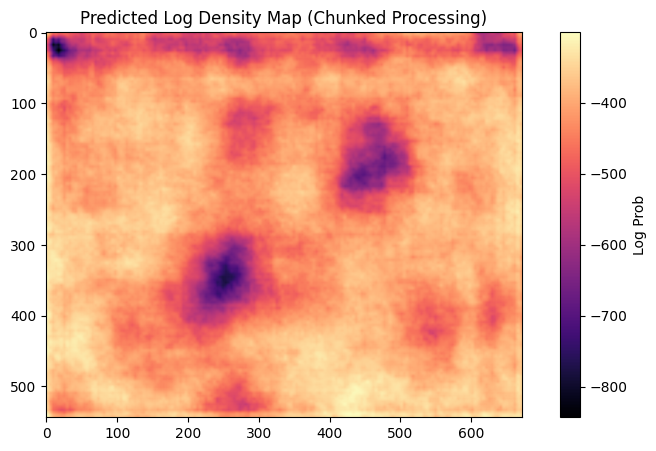

Visualization complete!


In [5]:
# 5. 可视化密度图 (使用分块处理防止内存爆炸)
with torch.no_grad():
    model.eval()
    # 提取全图特征
    features = model.feature_extractor.get_pixel_wise_features(dummy_image)
    B, C, H, W = features.shape
    feat_flat = features.permute(0, 2, 3, 1).reshape(-1, C)
    
    # --- 分块计算核心逻辑 ---
    chunk_size = 5000 # 每次只处理 5000 个像素，这个数值对内存非常友好
    all_log_densities = []
    
    print(f"Processing {feat_flat.shape[0]} pixels in chunks...")
    for i in range(0, feat_flat.shape[0], chunk_size):
        chunk = feat_flat[i : i + chunk_size]
        # 对这一小块像素计算密度
        log_density_chunk = model.density_estimator(chunk)
        all_log_densities.append(log_density_chunk)
    
    # 合并结果
    log_density = torch.cat(all_log_densities, dim=0)
    # -----------------------
    
    log_density_map = log_density.view(H, W).cpu().numpy()

# 绘图部分
plt.figure(figsize=(10, 5))
plt.title("Predicted Log Density Map (Chunked Processing)")
plt.imshow(log_density_map, cmap='magma')
plt.colorbar(label='Log Prob')
plt.show()

print("Visualization complete!")